In [1]:
#data manipulations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#model building
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#model evaluation
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
#create training and test set
train_set = "Training"
test_set = "Testing"

In [3]:
# Create ImageDataGenerator with Normalized pixel values to [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
#load and process the images
train_generator = train_datagen.flow_from_directory(train_set, target_size=(150,150), batch_size=20, class_mode='categorical' )
test_generator = test_datagen.flow_from_directory(test_set, target_size=(150,150), batch_size=20, class_mode='categorical')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


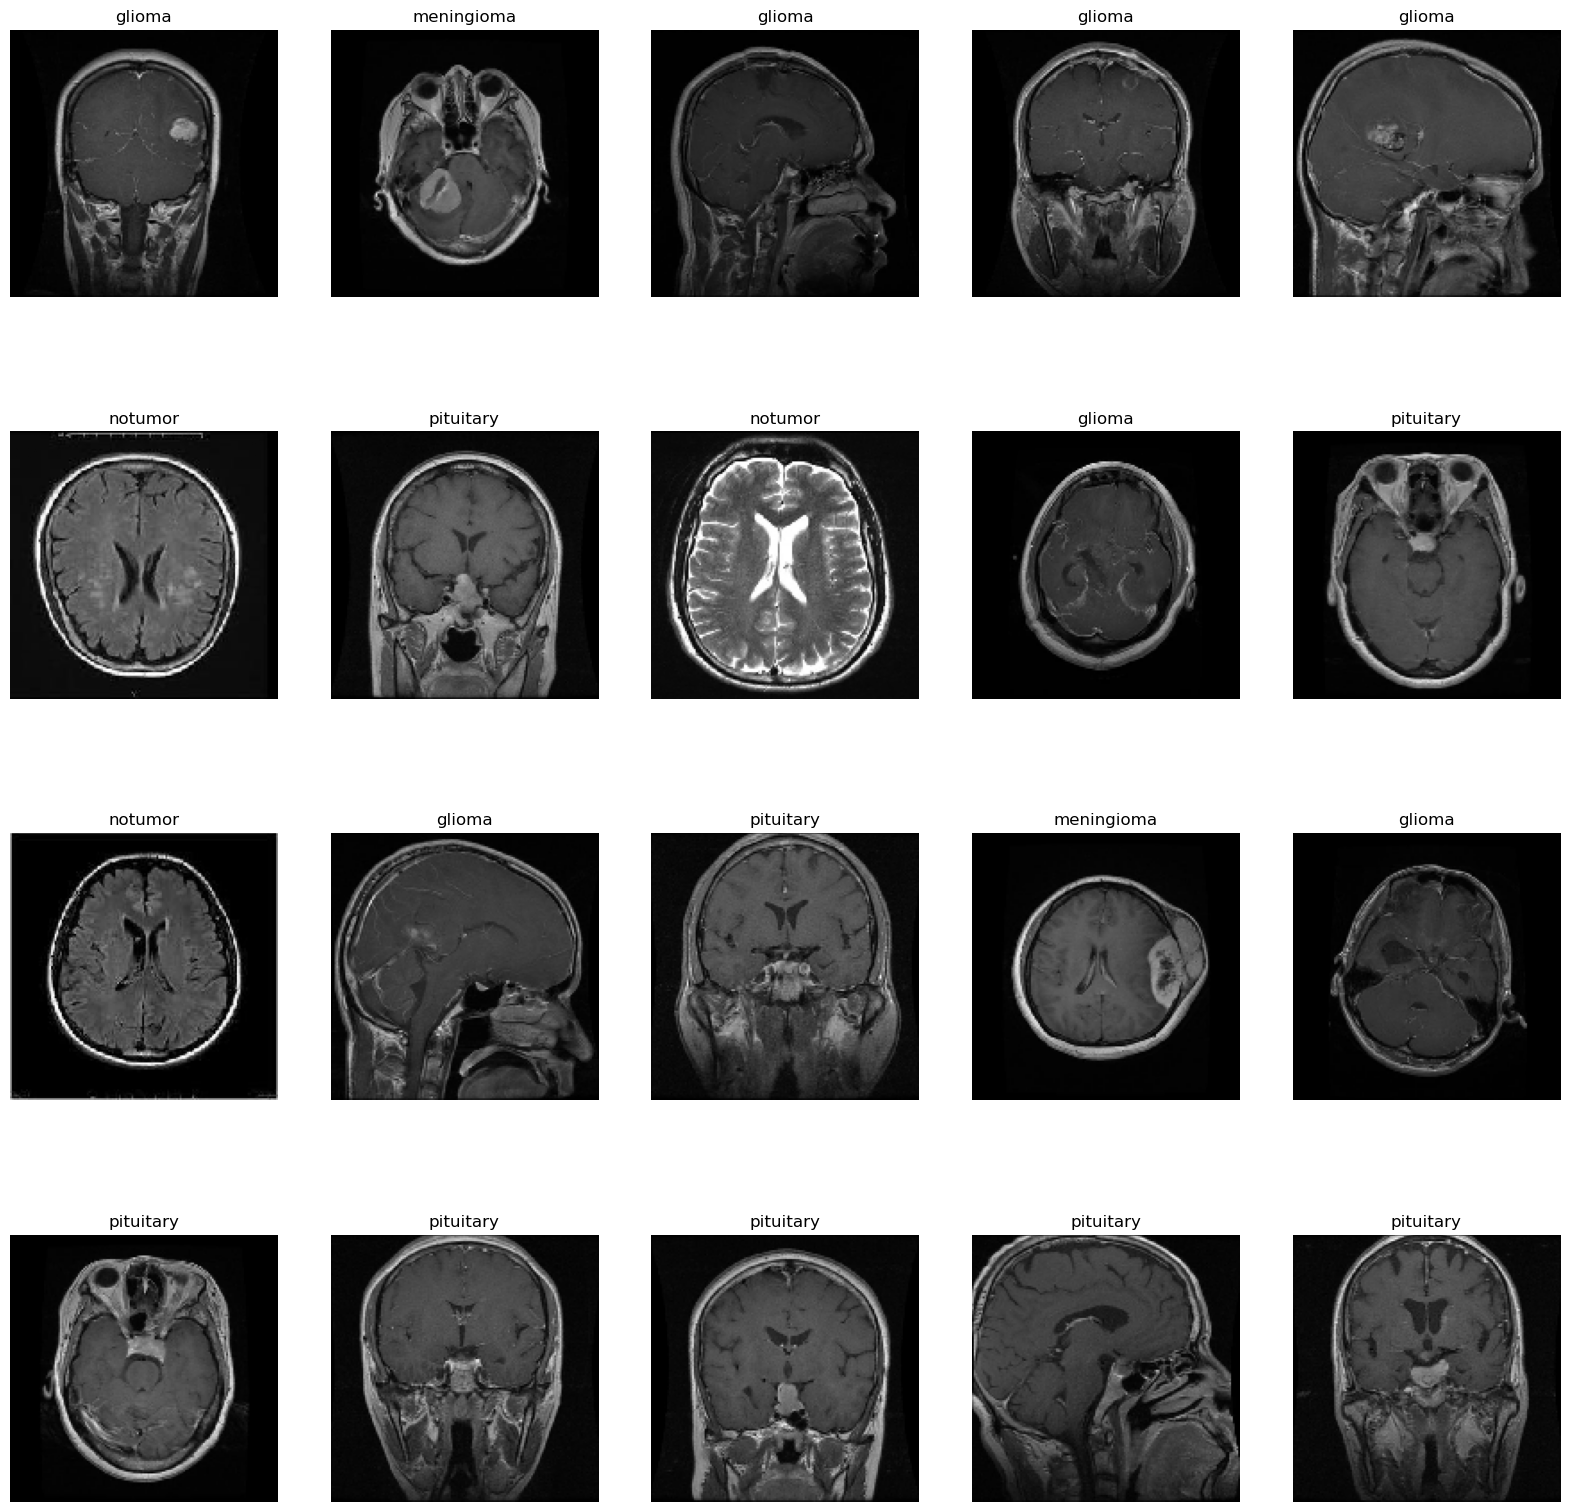

In [5]:
images, labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

#function to plot images
def plot_images(images, labels, class_names, num_images=20):
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(4, 5, i+1)  # 4 rows, 5 columns
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()
plot_images(images, labels, class_names)

In [6]:
#create the model
model = Sequential()
#first layer
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))
#second layer
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))
#third layer
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))
#fourth layer
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))
#flatten
model.add(Flatten())
#first dense layer          
model.add(Dense(512,activation='relu'))
#second dense layer          
model.add(Dense(4,activation='softmax'))

#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
#summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 128)       0

In [8]:
#prevent overfitting
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#save the best model
modelcheckpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

In [9]:
history = model.fit(train_generator, steps_per_epoch=100, validation_data=test_generator,shuffle=False,
                   validation_steps=None, epochs=20 , callbacks=[earlystop, modelcheckpoint])

Epoch 1/20


100/100 [==============================] - 84s 814ms/step - loss: 0.9536 - accuracy: 0.5770 - val_loss: 0.7097 - val_accuracy: 0.7056
Epoch 2/20
100/100 [==============================] - 83s 829ms/step - loss: 0.5789 - accuracy: 0.7620 - val_loss: 0.5674 - val_accuracy: 0.7513
Epoch 3/20
100/100 [==============================] - 96s 962ms/step - loss: 0.4923 - accuracy: 0.7990 - val_loss: 0.7725 - val_accuracy: 0.6339
Epoch 4/20
100/100 [==============================] - 85s 847ms/step - loss: 0.4171 - accuracy: 0.8420 - val_loss: 0.4601 - val_accuracy: 0.8131
Epoch 5/20
100/100 [==============================] - 92s 912ms/step - loss: 0.3061 - accuracy: 0.8915 - val_loss: 0.4240 - val_accuracy: 0.8368
Epoch 6/20
100/100 [==============================] - 92s 917ms/step - loss: 0.2423 - accuracy: 0.9100 - val_loss: 0.3715 - val_accuracy: 0.8627
Epoch 7/20
100/100 [==============================] - 84s 836ms/step - loss: 0.2275 - accuracy: 0.9175 - val_loss: 0.3022 - val_

<Axes: >

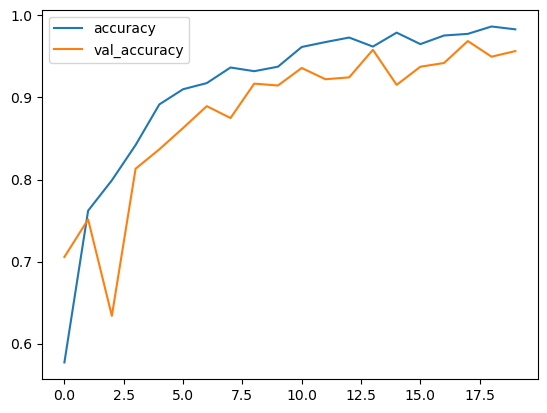

In [10]:
#plot accuracy 
accuracy = pd.DataFrame(history.history)
accuracy[['accuracy','val_accuracy']].plot()

<Axes: >

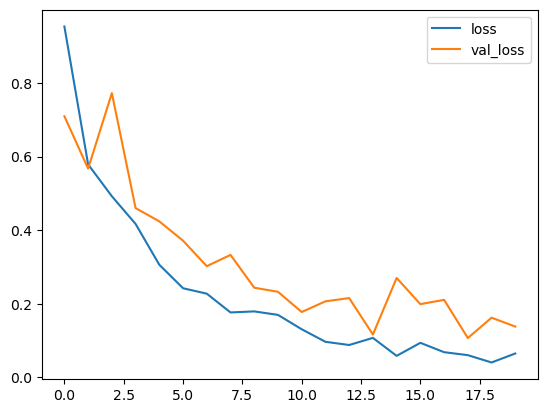

In [11]:
#plot losses
losses = pd.DataFrame(history.history)
losses[['loss','val_loss']].plot()

In [12]:

# Initialize lists to collect predictions and true labels
y_pred_list = []
y_true_list = []

# Predict in batches
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    y_pred_batch = model.predict(x_batch)
    
    # Convert predictions to class labels
    y_pred_class_batch = (y_pred_batch > 0.5).astype(int)  # Adjust as needed for multiclass
    
    # Collect predictions and true labels
    y_pred_list.append(y_pred_class_batch)
    y_true_list.append(y_batch)

# Flatten the lists
y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)


1/1 [==============================] - 0s 134ms/step


In [13]:
#classification report
print(classification_report(y_true,y_pred, target_names = list( test_generator.class_indices.keys()) ))

              precision    recall  f1-score   support

      glioma       0.98      0.87      0.92       300
  meningioma       0.87      0.96      0.91       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.99      0.99      0.99       300

   micro avg       0.96      0.96      0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311
 samples avg       0.96      0.96      0.96      1311



In [14]:
# Assuming y_true and y_pred are one-hot encoded or probabilities
y_true_single = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
y_pred_single = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred

# Compute confusion matrix
cm = confusion_matrix(y_true_single, y_pred_single)
print(cm)

[[262  37   0   1]
 [  5 295   4   2]
 [  0   4 401   0]
 [  0   4   0 296]]
